In [4]:
!pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pingouin as pg
import biutils 

from sklearn.preprocessing import StandardScaler,LabelEncoder 
from sklearn.model_selection import GridSearchCV,StratifiedGroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate, cross_val_score

we are using the datasets from the previous notebooks, feel free to modify it to something else with similar format.

In [2]:
# retrieve table from database
binary = biutils.get_tbl('binary')
no_out = biutils.get_tbl('bino_out')
zdata = biutils.get_tbl("bizdata")

In [3]:
mcolumns = list(binary.columns)
mcolumns.remove('voxel')
mcolumns.remove('label')
mcolumns.remove('dataset')
metlist = list(set([i.split(" ")[0] for i in mcolumns]))
len(metlist)
metrics = ['FAT14ratio','ratioWAT47_1d','ratioFAT14_1d','ratioFAT54_1d']
oned = ['nws_ffrac','nws_wfrac','nws_wfratio']


In [4]:

intervars =['triglycerylfatcrossp(TGFRupper) FAT14ratio', 
'methylfat(FMETD10) FAT14ratio', 
'olefinicfat(UFD54) FAT14ratio', 
'fat(4p2_3p9) FAT14ratio', 
'methylenefat(FAT21) FAT14ratio', 
'fat(2p06_1p32) ratioWAT47_1d', 
'adc', 'gly+myo FAT14ratio', 
'fat(1p32_0p9) FAT14ratio']

intername = ['TGFRupper/FAT14','FMETD/FAT14','UFD54/FAT14','CP8/FAT14',
'FAT21/FAT14','CP4/FAT14','ADC','mI+Gly/FAT14','CP2/FAT14']

renamed = no_out[intervars+['voxel','dataset','label']]
renamed = renamed.rename(columns=dict(zip(intervars,intername)))


## Train-test split

Getting train and test sets based on selected variables. 

To prevent repeated inclusion of data in the test sets:

we split based on dataset names, such that test and train sets do not share voxels from same datasets, by setting groups = dataset in the GroupShuffleSplit and (Stratified)GroupKFold methods. 

In [6]:
def tts(dat,vars, train_size = 0.8,rs=np.random.RandomState()): 
    X = dat[vars] #select feature
    y = LabelEncoder().fit_transform(dat.label) #select target, which is stored in the label column
    groups = dat[['dataset']]
    group_dict = dict(zip(dat.dataset,dat.label))
    gps = list(group_dict.keys()) #groups
    gl = list(group_dict.values()) #group label
    # the following code perform stratified shuffle split on the groups into train and test
    sss = StratifiedShuffleSplit(n_splits=1,train_size=train_size,random_state=rs) 
    for i, (train_index, test_index) in enumerate(sss.split(gps, gl)):
        #print(i)
        trds = [gps[idx] for idx in train_index] 
        teds = [gps[idx] for idx in test_index]
        g_train = groups[groups.dataset.isin(trds)].dataset
        g_test = groups[groups.dataset.isin(teds)].dataset
        #print(set(g_train).intersection(set(g_test))) 
        # then based on the groups we assign datapoints
        X_train = X.loc[dat.dataset.isin(g_train),vars]
        X_test = X.loc[dat.dataset.isin(g_test),vars]
        y_train = y[dat.dataset.isin(g_train)]
        y_test = y[dat.dataset.isin(g_test)]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test) #also perform standardization for both.
    return X_train,X_test,y_train,y_test,g_train,g_test


In [7]:
X_train,X_test,y_train,y_test,g_train,g_test = tts(no_out,mcolumns,rs=42)
print(len(X_train))
print(len(X_test))
#sanity check, if the random_State (rs) is 42, the number should be 350 and 86 for breast

350
86


How many datasets are in train and test

number of malignant voxels:
241
number of benign voxels:
195


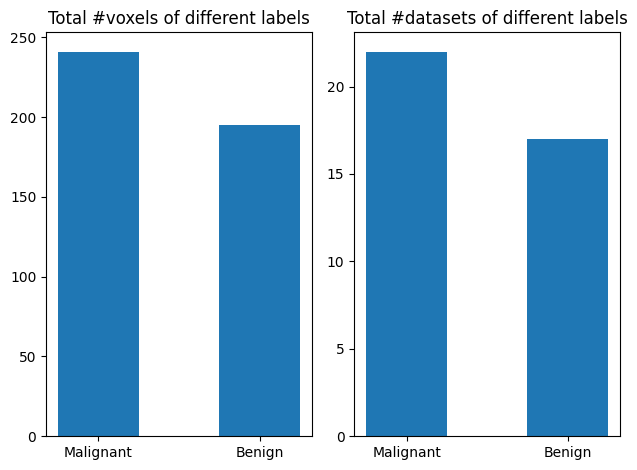

In [8]:
#outlier removed, class distributions
maglinantd, benignd = biutils.data_const(no_out)

In [9]:
print('==train==')
print('#malignant')
print(len(set(g_train).intersection(set(maglinantd))))
print('#benign')
print(len(set(g_train).intersection(set(benignd))))
print('==test==')
print('#malignant')
print(len(set(g_test).intersection(set(maglinantd))))
print('#benign')
print(len(set(g_test).intersection(set(benignd))))

==train==
#malignant
17
#benign
14
==test==
#malignant
5
#benign
3


In [10]:
#This code is just run to get train and test set index
train = no_out[no_out.dataset.isin(g_train.values)]
test = no_out[no_out.dataset.isin(g_test.values)]

final train and test sets

In [11]:
print('#train voxels')
print(len(train))
print('#test voxels')
print(len(test))

#train voxels
350
#test voxels
86


In [12]:
train

,methylfat(FMETD10) ratioFAT54_1d,methylenefat(FAT14) ratioFAT54_1d,methylenefat(FAT21) ratioFAT54_1d,methylenefat(FAT23) ratioFAT54_1d,methylenefat(FAT29) ratioFAT54_1d,tcholine(CHO32) ratioFAT54_1d,fat39(fat39) ratioFAT54_1d,methyleneglycerolbackbone(MGB42) ratioFAT54_1d,olefinicfat(UFD54) ratioFAT54_1d,unsatfatrightcrossp(UFRlower) ratioFAT54_1d,...,fat(2p06_1p32) ratioWAT47_1d,fat(3p9_4p3) ratioWAT47_1d,fat(4p2_3p9) ratioWAT47_1d,gly+myo ratioWAT47_1d,label,nws_ffrac,nws_wfratio,nws_wfrac,adc,dataset
0,0.00677,0.02733,0.00125,0.00116,0.00043,0.00001,0.00016,0.00051,0.00329,0.00015,...,0.02083,0.00074,0.00114,0.00011,benign,0.131044,16.817404,0.868956,1.77800,data005
1,0.00616,0.02613,0.00108,0.00105,0.00038,0.00001,0.00011,0.00036,0.00269,0.00011,...,0.02217,0.00031,0.00093,0.00010,benign,0.125370,17.496441,0.874630,1.77800,data005
2,0.00630,0.02667,0.00116,0.00112,0.00041,0.00001,0.00014,0.00046,0.00334,0.00013,...,0.02095,0.00062,0.00102,0.00012,benign,0.124689,19.061213,0.875311,1.77800,data005
3,0.00702,0.02828,0.00117,0.00112,0.00042,0.00001,0.00014,0.00046,0.00291,0.00014,...,0.02350,0.00037,0.00109,0.00010,benign,0.137687,15.190081,0.862313,1.77800,data005
4,0.00566,0.02320,0.00095,0.00093,0.00033,0.00001,0.00011,0.00035,0.00254,0.00011,...,0.02312,0.00057,0.00102,0.00009,benign,0.116809,18.649412,0.883191,1.77800,data005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.06369,0.33568,0.01055,0.00862,0.00224,0.00000,0.00294,0.00901,0.03201,0.00147,...,0.15596,0.00311,0.00167,0.00000,malignant,0.733479,0.635733,0.266520,1.54665,dataMLT
414,0.04438,0.29407,0.00907,0.00594,0.00198,0.00000,0.00158,0.00799,0.02515,0.00099,...,0.21653,0.00193,0.00084,0.00000,malignant,0.716097,0.623264,0.283903,1.54665,dataMLT
415,0.05731,0.40454,0.01048,0.00762,0.00322,0.00000,0.00184,0.01068,0.03033,0.00079,...,0.30665,0.00280,0.00088,0.00000,malignant,0.789320,0.404949,0.210680,1.54665,dataMLT
416,0.04522,0.24652,0.00676,0.00499,0.00193,0.00000,0.00207,0.00663,0.02267,0.00089,...,0.13652,0.00237,0.00105,0.00000,malignant,0.682538,0.834575,0.317462,1.54665,dataMLT


In [34]:
train.to_csv('train.csv')
test.to_csv('test.csv') #data frames.

Text(0.5, 0.98, 'Label distributions')

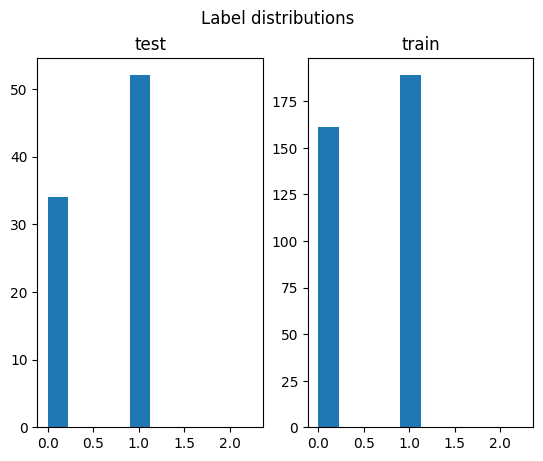

In [13]:
#visualize label distributions 
plt.subplot(1,2,1)
plt.hist(y_test,range=(0,2.25),align='mid')
plt.title('test')
plt.subplot(1,2,2)
plt.hist(y_train,range=(0,2.25),align='mid')
plt.title('train')
plt.suptitle('Label distributions')

## Statistical tests on train data only

In [14]:
#mwu tests on the train data
mwu = pd.DataFrame()
for i in range(len(mcolumns)):
    var = mcolumns[i]
    df = train.loc[:,[var,'label']]
    update = pg.mwu(x = df[df.label == 'benign'][var],y = df[df.label == 'malignant'][var]) 
    mwu = pd.concat([mwu,update])
mwu['met'] = mcolumns
mwu['valid'] = mwu['p-val'] < 0.01
varsmwu = list(mwu[mwu.valid].met)
print(len(mwu[mwu.valid].met.unique()))

print(X_train.shape)
print(X_test.shape)


87
(350, 99)
(86, 99)


In [15]:
#350x87, 86x87 subsetting the part with features passing the statistical tests
X_train,X_test,y_train,y_test,g_train,g_test = tts(no_out,varsmwu,rs=42)
print(X_train.shape)
print(X_test.shape)

(350, 87)
(86, 87)


In [16]:
varsmwu

['methylfat(FMETD10) ratioFAT54_1d',
 'methylenefat(FAT14) ratioFAT54_1d',
 'methylenefat(FAT21) ratioFAT54_1d',
 'methylenefat(FAT23) ratioFAT54_1d',
 'methylenefat(FAT29) ratioFAT54_1d',
 'fat39(fat39) ratioFAT54_1d',
 'methyleneglycerolbackbone(MGB42) ratioFAT54_1d',
 'olefinicfat(UFD54) ratioFAT54_1d',
 'unsatfatrightcrossp(UFRlower) ratioFAT54_1d',
 'unsatfatleftcrossp(UFLlower) ratioFAT54_1d',
 'unsatfatrightcrossp(UFRupper) ratioFAT54_1d',
 'unsatfatleftcrossp(UFLupper) ratioFAT54_1d',
 'triglycerylfatcrossp(TGFRlower) ratioFAT54_1d',
 'triglycerylfatcrossp(TGFRupper) ratioFAT54_1d',
 'fat(0p9_1p32) ratioFAT54_1d',
 'fat(1p32_0p9) ratioFAT54_1d',
 'fat(1p64_2p36) ratioFAT54_1d',
 'fat(2p36_1p64) ratioFAT54_1d',
 'fat(1p32_2p06) ratioFAT54_1d',
 'fat(2p06_1p32) ratioFAT54_1d',
 'fat(3p9_4p3) ratioFAT54_1d',
 'fat(4p2_3p9) ratioFAT54_1d',
 'methylfat(FMETD10) FAT14ratio',
 'methylenefat(FAT21) FAT14ratio',
 'methylenefat(FAT23) FAT14ratio',
 'methylenefat(FAT29) FAT14ratio',
 'tch

## List of models and hyperparameter grid

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [18]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 



names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
   # "Gaussian Process",
    "Decision Tree",
    "Neural Net",
    "Naive Bayes",
    "QDA"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025,random_state = 42),
    SVC(gamma=2, C=1,random_state = 42),
   # GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),#took toolong
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(alpha=1, max_iter=1000,random_state = 42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score =clf.score(X_test, y_test)
    print(name+" "+str(score))

    

Nearest Neighbors 0.5697674418604651
Linear SVM 0.7558139534883721
RBF SVM 0.6046511627906976
Decision Tree 0.813953488372093
Neural Net 0.7558139534883721
Naive Bayes 0.5581395348837209
QDA 0.627906976744186


/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


retreive model params

In [19]:
GaussianNB().get_params()

{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'tol': 0.0001}

### Model 0: linear svm

In [20]:
# Optimize linear SVM
lsvc = SVC(kernel="linear", random_state = 42)
# gridsearch
svm_grid = {'C': [0.01,0.02,0.05,0.1,0.15,0.2]} 
svm_gridcv = GridSearchCV(lsvc, svm_grid, verbose = 0,cv = StratifiedGroupKFold(5))
svm_gridcv.fit(X_train,y_train,groups=g_train)
print(svm_gridcv.best_estimator_)
print(svm_gridcv.best_score_)


SVC(C=0.02, kernel='linear', random_state=42)
0.9012132433867229


In [21]:

sc = []
cc = []
C = np.arange(0.01,1,0.01)
for i in C:
    svct = SVC(kernel="linear",C = i, random_state = 42)
    scc = np.mean(cross_val_score(svct,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)
    cc.append(i)


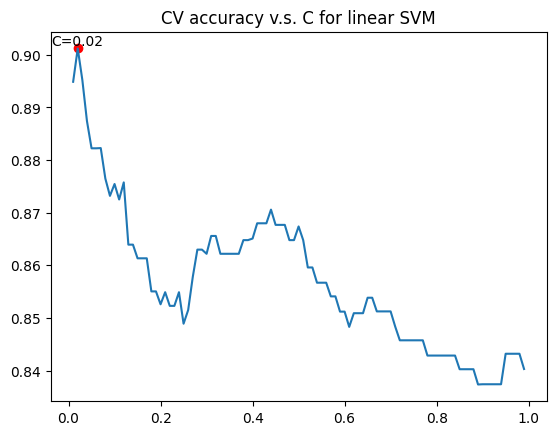

In [22]:

plt.scatter(cc[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(cc,sc)
plt.text(cc[sc.index(max(sc))], max(sc), 'C='+str(cc[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. C for linear SVM')
plt.show()


optimal svm

In [ ]:
svc_opt = SVC(kernel="linear", C = 0.02,random_state = 42)

## Bagging method

In [30]:
from sklearn.ensemble import BaggingClassifier


### Bagging Classifier

Aim at reducing variances by combining the predictions of multiple independent estimators (homogenous)

Decision Tree-based Bagging Clssifier performs better than the random forest based one, attaining 88.75% accuracy on test sets.

### Model 1: DT based bagging classifier

In [ ]:
dt_grid ={'bootstrap': [True, False],
'bootstrap_features': [True, False],    
'n_estimators': [5, 10, 15],
'max_samples' : [0.6, 0.8, 1.0],   
'base_estimator__max_depth' : [1, 2, 3, 4, 5, 10, 20, 50],
'base_estimator__max_features' : [0.6, 0.8, 1.0]}


dtc = DecisionTreeClassifier(random_state = 42)
baggingdt = BaggingClassifier(dtc,random_state = 42)
bagdt_cv = GridSearchCV(baggingdt,dt_grid, verbose = 0,cv = StratifiedGroupKFold(5))
bagdt_cv.fit(X_train,y_train,groups=g_train)
print(bagdt_cv.best_estimator_)
print(bagdt_cv.best_score_)

In [ ]:
#Grid for svc-based bagging classifier
lm_grid ={'bootstrap': [True, False],
'bootstrap_features': [True, False],    
'n_estimators': [5, 10, 15],
'max_samples' : [0.6, 0.8, 1.0],   
'base_estimator__C':[0.0001,0.005,0.02,0.0015,0.025,0.01,0.1, 0.25,1]}

bagginglm = BaggingClassifier(SVC(kernel="linear", C = 0.0015,random_state = 42),random_state = 42)


In [ ]:
baglm_cv = GridSearchCV(bagginglm,lm_grid, verbose = 0,cv = StratifiedGroupKFold(5))
baglm_cv.fit(X_train,y_train,groups=g_train)
print(baglm_cv.best_estimator_)
print(baglm_cv.best_score_)

In [ ]:
#bt_opt = BaggingClassifier(base_estimator=SVC(C=0.02, kernel='linear', random_state=42),
  #                bootstrap=False, bootstrap_features=True, max_samples=0.6,
   #               n_estimators=5, random_state=42)

In [ ]:
sc = []
steps = np.arange(1,20,2)
for i in steps:
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                        max_features=1.0,
                                                        random_state=42),
                  bootstrap_features=True, max_samples=0.6, n_estimators=i,
                  random_state=42)
    scc = np.mean(cross_val_score(model,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)




In [ ]:

plt.scatter(steps[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(steps,sc)
plt.text(steps[sc.index(max(sc))], max(sc), 'n='+str(steps[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. #estimators for DT-based bagging')
plt.show()

optimal bagging

In [ ]:


bt_opt = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                        max_features=1.0,
                                                        random_state=42),
                  bootstrap_features=True, max_samples=0.6, n_estimators=13,
                  random_state=42)

### Random Forest Classifier

 a meta estimator that fits a number of base tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting  

Doesn't seem promising. 

In [31]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier


In [ ]:
rfc = RandomForestClassifier(n_estimators=200,random_state=42)
rfc.fit(X_train,y_train)
rfcsc = rfc.score(X_test,y_test)
#extra random forest 
exrfc = ExtraTreesClassifier(n_estimators=200, max_depth=None,
    min_samples_split=2, random_state=42)
exrfc.fit(X_train,y_train)
exrfcsc = exrfc.score(X_test,y_test)
print("Extra RandomForest: "+str(exrfcsc))
print("RandomForest: "+str(rfcsc))


### Model 2: Random Forest


In [ ]:
n_estimators = np.arange(1,200,50)
# Maximum nucmber of levels in tree
max_depth = [1,3,5,10,15]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(random_state=42)
r_cv = GridSearchCV(rfc, random_grid, verbose = 0,cv = StratifiedGroupKFold(5))
r_cv.fit(X_train,y_train,groups=g_train)
print(r_cv.best_estimator_)
print(r_cv.best_score_)

In [ ]:
sc = []
steps = np.arange(10,500,10)
for i in steps:
    classifier = RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_split=10,
                       n_estimators=i, random_state=42)
    scc = np.mean(cross_val_score(classifier,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)



plt.scatter(steps[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(steps,sc)
plt.text(steps[sc.index(max(sc))], max(sc), 'n='+str(steps[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. #estimators for RF')
plt.show()

optimal random forest

In [ ]:
rf_opt = RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_split=10,
                       n_estimators=40, random_state=42)

### Voting Classifier
Combine conceptually different machine learning algorithms using a majority vote or soft vote to average performance (heterogenous) 

With other choices of based learners, voting classifier could potentially reach higher classification accuracies. 

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
rbfsvc = SVC(gamma=2, C=1,random_state = 42)
dt = DecisionTreeClassifier(max_depth=5,random_state = 42)
nb = GaussianNB()
rfc = RandomForestClassifier(n_estimators=200,random_state=42)

eclf = VotingClassifier(
    estimators=[('rbf svc', rbfsvc), ('dt', dt), ('nb', nb),('rfc', rfc)],
    voting='hard')

for clf, label in zip([rbfsvc,dt,nb,rfc, eclf], ['RBF SVC', 'Decision Tree', 'Naive Bayes','Random Forest', 'Ensemble']):
    clf.fit(X_train,y_train)
    print(label)
    print(clf.score(X_test,y_test))


## Boosting method  

Aim at reducing bias by sequentially combining weak base learners that learn from previous mistakes (also homogenous)

Gradient Boosting and Extra Gradient Boosting methods show potentials. 

https://datascience.stackexchange.com/questions/74488/tuning-parameters-for-gradient-boosting-xgboost

### Adaboost: SVC base learners

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


In [ ]:
# SVC AS BASE

rbfsvc2 = SVC(gamma=2,random_state = 42)
clf = AdaBoostClassifier(n_estimators=100,base_estimator = rbfsvc2,algorithm='SAMME') #SVC above
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:

clf = AdaBoostClassifier(n_estimators=30) #SVC above
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

### Model 3: Ada Boost

In [ ]:
ada_grid = dict()

# estimator till 500
ada_grid['n_estimators'] = np.arange(10,200,10)

# defining learning rate
ada_grid['learning_rate'] = [0.0001, 0.01, 0.1, 1.0, 1.5]


ada_grid['base_estimator__max_depth']= [1, 3, 5, 10, 20]
ada_grid['base_estimator__max_features']=[0.6, 0.8, 1.0]
adamdl = AdaBoostClassifier(DecisionTreeClassifier(),random_state = 42)
ada_gridcv = GridSearchCV(estimator=adamdl, param_grid=ada_grid,cv=StratifiedGroupKFold(5))
ada_gridcv.fit(X_train,y_train,groups=g_train)
print(ada_gridcv.best_estimator_)
print(ada_gridcv.best_score_)

In [ ]:
sc = []
steps = np.arange(10,200,10)
for i in steps:
    classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         max_features=0.6),
                   learning_rate=0.1, n_estimators=i, random_state=42)
    scc = np.mean(cross_val_score(classifier,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)


In [ ]:
plt.scatter(steps[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(steps,sc)
plt.text(steps[sc.index(max(sc))], max(sc), 'n='+str(steps[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. #estimators for AdaBoost')
plt.show()

optimal ada


In [ ]:
ada_opt =  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         max_features=0.6),
                   learning_rate=0.1, n_estimators=100, random_state=42)



### Gradient boost:
 trees based, can't alter

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:

glf = GradientBoostingClassifier(n_estimators=100, random_state=42,warm_start=False)

glf.fit(X_train, y_train)
glf.score(X_test, y_test)

### Model 4: Gradient Boost


In [ ]:
learning_rates = [1, 0.5,0.1]
n_estimators = np.arange(10,200,10)
max_depths = [2, 3, 5, 10,20,30]
min_samples_split = np.linspace(0.1, 1.0, 3, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 3, endpoint=True)


# Define the grid of hyperparameters to search
glf_grid = {
    'max_depth':max_depths,
    'learning_rate':learning_rates,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leafs
    }

    #parameters = {
    #"loss":["deviance"],
    #"learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
   # "min_samples_split": np.linspace(0.1, 0.5, 12),
   # "min_samples_leaf": np.linspace(0.1, 0.5, 12),
   # "max_depth":[3,5],
   # "max_features":["log2","sqrt"],
   # "criterion": ["friedman_mse",  "mae"],
   # "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #"n_estimators":[10,50,200]
    #}


glf = GradientBoostingClassifier(random_state=42,warm_start=False)
glf_gridcv = GridSearchCV(glf, glf_grid,cv=StratifiedGroupKFold(5))
glf_gridcv.fit(X_train,y_train,groups=g_train)

In [ ]:
print(glf_gridcv.best_estimator_)
print(glf_gridcv.best_score_)

In [ ]:
sc = []
steps = np.arange(10,300,10)
for i in steps:
    classifier = GradientBoostingClassifier(n_estimators = i,learning_rate=0.5, max_depth=10,
                           min_samples_leaf=0.1, min_samples_split=0.1,
                           random_state=42)
    scc = np.mean(cross_val_score(classifier,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)



plt.scatter(steps[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(steps,sc)
plt.text(steps[sc.index(max(sc))], max(sc), 'n='+str(steps[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. #estimators for GradientBoost')
plt.show()

gradient boost optimal

glf_opt = GradientBoostingClassifier(n_estimators =50 ,learning_rate=0.5, max_depth=10,
                           min_samples_leaf=0.1, min_samples_split=0.1,
                           random_state=42)

### XGBoost    

https://datascience.stackexchange.com/questions/35713/i-got-100-accuracy-on-my-test-set-is-there-something-wrong   # good advice  

1) xgb rf https://xgboost.readthedocs.io/en/stable/tutorials/rf.html
    prevent overfitting
2) stratified kboost https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html 
    mediate class balance 

In [ ]:
import xgboost as xgb 


In [ ]:
xgbrf = xgb.XGBRFClassifier(objective="binary:logistic",random_state = 42)

xgbrf.fit(X_train, y_train)
xgbrf.score(X_test, y_test)

In [ ]:
xgbc = xgb.XGBClassifier(objective="binary:logistic",random_state = 42)
xgbc.fit(X_train, y_train)
xgbc.score(X_test, y_test)

### Model 5: XGBoost



In [ ]:
# xgb grid
#base_score=[0.25,0.5,1]
n_estimators = np.arange(10,200,20)
max_depth = [2, 3, 5, 10]
booster=['gbtree']
learning_rate=[0.1,0.5,1]
min_child_weight=[1,2,3]

# Define the grid of hyperparameters to search
xgb_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    #'base_score':base_score
    }

xgbc = xgb.XGBClassifier(random_state = 42,)
xgb_gridcv = GridSearchCV(xgbc, xgb_grid,cv=StratifiedGroupKFold(5))
xgb_gridcv.fit(X_train,y_train,groups=g_train)

In [ ]:
print(xgb_gridcv.best_estimator_)
print(xgb_gridcv.best_score_)

In [ ]:
sc = []
steps = np.arange(10,300,10)
for i in steps:
    classifier = xgb.XGBClassifier(booster='gbtree', learning_rate=0.5, 
              min_child_weight=3,
              n_estimators=i,random_state=42)
    scc = np.mean(cross_val_score(classifier,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)



plt.scatter(steps[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(steps,sc)
plt.text(steps[sc.index(max(sc))], max(sc), 'n='+str(steps[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. #estimators for XGBoost')
plt.show()

optimal extreme gradient boost 

In [ ]:
xgb_opt = xgb.XGBClassifier(booster='gbtree', learning_rate=0.5, 
              min_child_weight=3,
              n_estimators=20,random_state=42)

### Catboost

In [ ]:
from catboost import CatBoostClassifier


In [ ]:

cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)
cat.score(X_test, y_test)
#'Wilcoxon', 'IncToDec', 'Iter'. 
#https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier 

### Model 6: Catboost


In [ ]:
catm = CatBoostClassifier(verbose=0)
grid = {'learning_rate': [0.03, 0.1,0.1],
        'n_estimators': [10, 50, 100, 150, 200]
        }

grid_search_result = catm.grid_search(grid, 
                                      cv = StratifiedGroupKFold(5),
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

In [ ]:
catm = CatBoostClassifier(verbose=0)
grid = {'learning_rate': [0.03, 0.1,0.1],
        'n_estimators': [10, 50, 100, 150, 200]
        }

grid_search_result = catm.grid_search(grid, 
                                      cv = StratifiedGroupKFold(5),
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)
grid_search_result['params']


In [ ]:
sc = []
steps = np.arange(10,500,50)
for i in steps:
    classifier = CatBoostClassifier(**{'n_estimators':i,'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.1},random_state=42,verbose=0)
    scc = np.mean(cross_val_score(classifier,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)



plt.scatter(steps[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(steps,sc)
plt.text(steps[sc.index(max(sc))], max(sc), 'n='+str(steps[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. #estimators for CatBoost')
plt.show()

optimal catboost

In [ ]:
cat_opt = CatBoostClassifier(**{'n_estimators':310,'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.1},random_state=42,verbose=0)

### Light Gradient Boost   
(Faster ver. of gradient boost)

See external notebook: 
https://colab.research.google.com/drive/1cjJutDZvMGfTFOcr_URfSQEq8Pe3LlF3?usp=sharing  

There is also a lightGBM inspired regression tree based gradient boosting classifier called [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) that is basically a faster implementation that could impute missing values.  


## Decision tree

#### Model 7: Decision tree

In [ ]:
tree = DecisionTreeClassifier(max_depth=5),#,random_state = 42
# Define the parameter grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [ 5, 10, 15,20,30,40,None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(dt_classifier, param_grid, cv=StratifiedGroupKFold(5))
grid_search.fit(X_train, y_train,groups=g_train)

# Get the best hyperparameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)
print(grid_search.best_estimator_)

In [ ]:

sc = []
steps = np.arange(10,100,10)
for i in steps:
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=i, min_samples_leaf=2,
                       min_samples_split=10)
    scc = np.mean(cross_val_score(classifier,X_train,y_train,cv=StratifiedGroupKFold(5),verbose=0,groups=g_train))
    sc.append(scc)

plt.scatter(steps[sc.index(max(sc))], max(sc), marker='o', color='red')
plt.plot(steps,sc)
plt.text(steps[sc.index(max(sc))], max(sc), 'n='+str(steps[sc.index(max(sc))]), ha='center', va='bottom')
plt.title('CV accuracy v.s. #estimators for Decision tree')
plt.show()

optimal decision tree

In [ ]:
tree_opt = DecisionTreeClassifier(criterion='entropy', max_depth=60, min_samples_leaf=2,
                       min_samples_split=10)